In [21]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import os
import wave
import librosa
import numpy as np
from scipy.signal import find_peaks
from tqdm import tqdm
import pandas as pd

directory = 'train'
files = []

file_list = [filename for filename in os.listdir(directory) if filename.endswith(".wav")]

for filename in tqdm(file_list, desc="Processing files"):
    file_path = os.path.join(directory, filename)
    try:
        y, sr = librosa.load(file_path, sr=None)
        frame_length = 2048
        hop_length = 512
        rms = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)[0]
        peaks, _ = find_peaks(rms, height=np.mean(rms) + 0.5 * np.std(rms), distance=sr/(hop_length*2))
        min_distance = 0.4  
        current_group = []
        group_2 = []

        for i in range(len(peaks)-1):
            if (peaks[i] - peaks[i+1]) >= -30:
                current_group.append(peaks[i])
        files.append([filename.split('.wav')[0], len(current_group)])
    except Exception as e:
        files.append([filename.split('.wav')[0], 0])
files_df = pd.DataFrame(files, columns=['id', 'ring_count'])
files_df['id'] = files_df['id'].astype(float)

Processing files:   0%|          | 0/2833 [00:00<?, ?it/s]

Processing files:  37%|███▋      | 1039/2833 [01:48<02:18, 12.95it/s]C:\Users\admin\AppData\Local\Temp\ipykernel_16092\1203384729.py:22: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None)
c:\Main\prog\py\Lib\site-packages\librosa\core\audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Processing files: 100%|██████████| 2833/2833 [04:10<00:00, 11.33it/s]


In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Разделение данных на обучающую и тестовую выборки
X = df.drop(columns=['Успешный результат'])
y = df['Успешный результат']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param = {
    'max_depth': 5,
    'learning_rate': 0.011,
    'n_estimators': 189,
    'subsample': 0.77,
    'colsample_bytree': 0.73,
    'gamma': 0.16,
    'min_child_weight': 5
}

model = xgb.XGBClassifier(**param)

# Обучение модели
model.fit(X_train, y_train)

# Предсказание вероятностей на тестовой выборке
y_proba = model.predict_proba(X_test)

# Установка порога уверенности
threshold = 0.44  # Пример: изменить порог на 0.6

# Применение порога для получения окончательных предсказаний
y_pred = (y_proba[:, 1] >= threshold).astype(int)

# Оценка точности модели
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

accuracy, precision, recall, f1


(0.8977072310405644,
 0.8647798742138365,
 0.9482758620689655,
 0.9046052631578947)

In [31]:
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Accuracy: 0.8977072310405644
Precision: 0.8647798742138365
Recall: 0.9482758620689655
F1 Score: 0.9046052631578947


In [27]:
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import xgboost as xgb

df = pd.read_csv('train/info.csv', sep=';')
merged_df = df.merge(files_df, left_on='ID записи', right_on='id', how='left')
df = merged_df.drop(['id'],axis=1)
df.fillna(0)
df['ring_count'] = df['ring_count'].astype(float)
df = pd.get_dummies(df)
df = df.astype(float)
df.head()

# Определение функции для оптимизации
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 0.01, 0.2),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'use_label_encoder': False,
        'eval_metric': 'logloss'
    }

    model = xgb.XGBClassifier(**param)
    cv_scores = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy', n_jobs=-1)
    return cv_scores.mean()

# Создание и запуск Optuna-исследования
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Лучшие параметры
best_params = study.best_params
print(f"Лучшие параметры: {best_params}")

# Обучение модели с лучшими параметрами
best_model = xgb.XGBClassifier(**best_params)
best_model.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = best_model.predict(X_test)

# Оценка точности модели на тестовой выборке
result = accuracy_score(y_test, y_pred)
print(f"Точность модели на тестовой выборке: {result}")


[I 2024-06-23 10:20:32,825] A new study created in memory with name: no-name-62c5ac33-4f12-4566-93a3-1554107b48f3
C:\Users\admin\AppData\Local\Temp\ipykernel_16092\192654437.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\admin\AppData\Local\Temp\ipykernel_16092\192654437.py:21: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\admin\AppData\Local\Temp\ipykernel_16092\192654437.py:22: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0.

Лучшие параметры: {'max_depth': 3, 'learning_rate': 0.02629234823102906, 'n_estimators': 165, 'subsample': 0.8416755853268952, 'colsample_bytree': 0.9398956200185535, 'gamma': 0.0402691124396944, 'min_child_weight': 3}
Точность модели на тестовой выборке: 0.8994708994708994


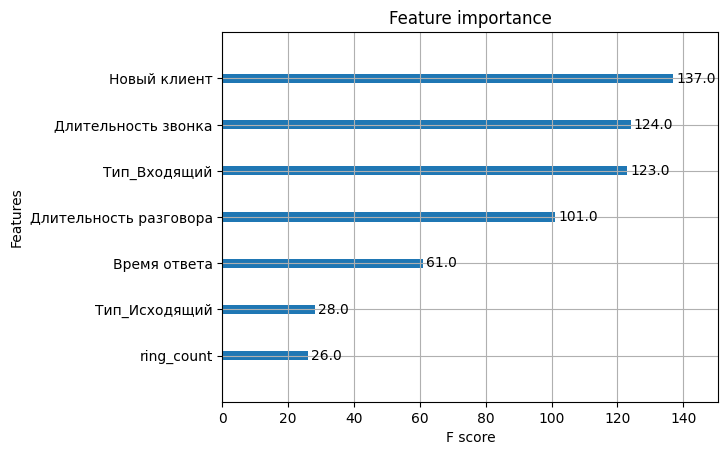

In [56]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Допустим, у вас уже есть обученная модель best_model
xgb.plot_importance(best_model, max_num_features=20)  # Укажите нужное количество признаков
plt.show()

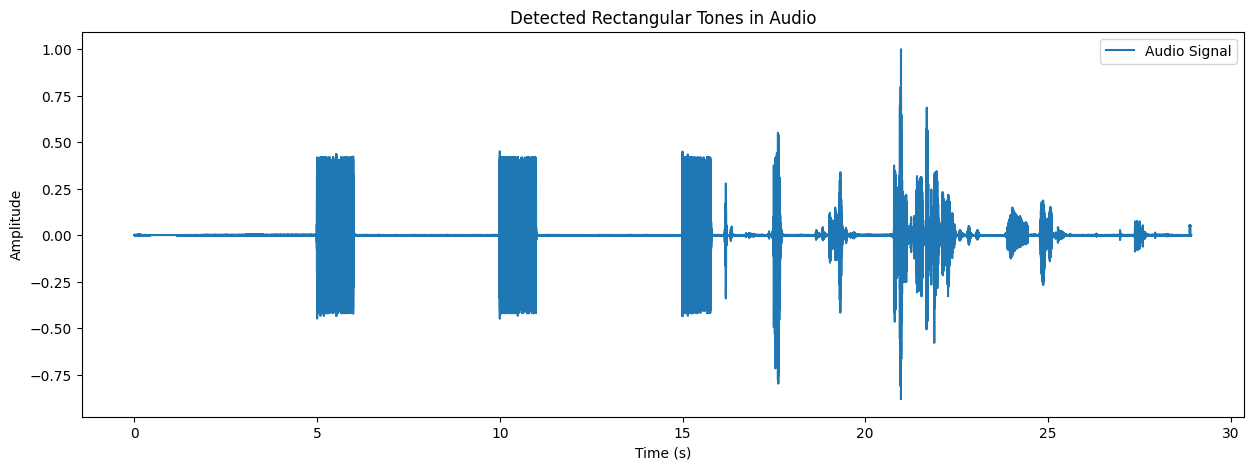

In [33]:
import matplotlib.pyplot as plt
from pydub import AudioSegment
import numpy as np

# Загрузить аудиофайл
audio = AudioSegment.from_file("train/1652862896.382947.wav")

# Преобразовать аудиофайл в массив данных
audio_data = np.array(audio.get_array_of_samples())

# Преобразовать стерео в моно, если необходимо
if audio.channels == 2:
    audio_data = audio_data.reshape((-1, 2)).sum(axis=1) / 2

# Нормализовать данные
audio_data = audio_data / np.max(np.abs(audio_data))

# Функция распознавания прямоугольных гудков
def detect_rectangular_tones(audio_data, min_threshold=-0.5, max_threshold=0.5, sample_rate=44100, min_duration=0.8, max_duration=1.2):
    min_samples = int(min_duration * sample_rate)
    max_samples = int(max_duration * sample_rate)
    tones = []
    current_tone = []
    
    for i in range(len(audio_data)):
        if min_threshold <= np.abs(audio_data[i]) <= max_threshold:
            current_tone.append(i)
        else:
            if min_samples <= len(current_tone) <= max_samples:
                tones.append((current_tone[0], current_tone[-1]))
            current_tone = []

    # Проверка последнего сегмента
    if min_samples <= len(current_tone) <= max_samples:
        tones.append((current_tone[0], current_tone[-1]))

    return tones

# Установить параметры
sample_rate = audio.frame_rate
min_threshold = -0.5  # нижний порог амплитуды
max_threshold = 0.5  # верхний порог амплитуды
min_duration = 0.8  # минимальная длительность гудка в секундах
max_duration = 1.2  # максимальная длительность гудка в секундах

# Распознать гудки
tones = detect_rectangular_tones(audio_data, min_threshold, max_threshold, sample_rate, min_duration, max_duration)

# Создать временной массив
time = np.arange(len(audio_data)) / sample_rate

# Отобразить график с гудками
plt.figure(figsize=(15, 5))
plt.plot(time, audio_data, label="Audio Signal")

# Отметить гудки на графике
for tone in tones:
    start_time = tone[0] / sample_rate
    end_time = tone[1] / sample_rate
    plt.axvspan(start_time, end_time, color='red', alpha=0.5)

plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Detected Rectangular Tones in Audio")
plt.legend()
plt.show()


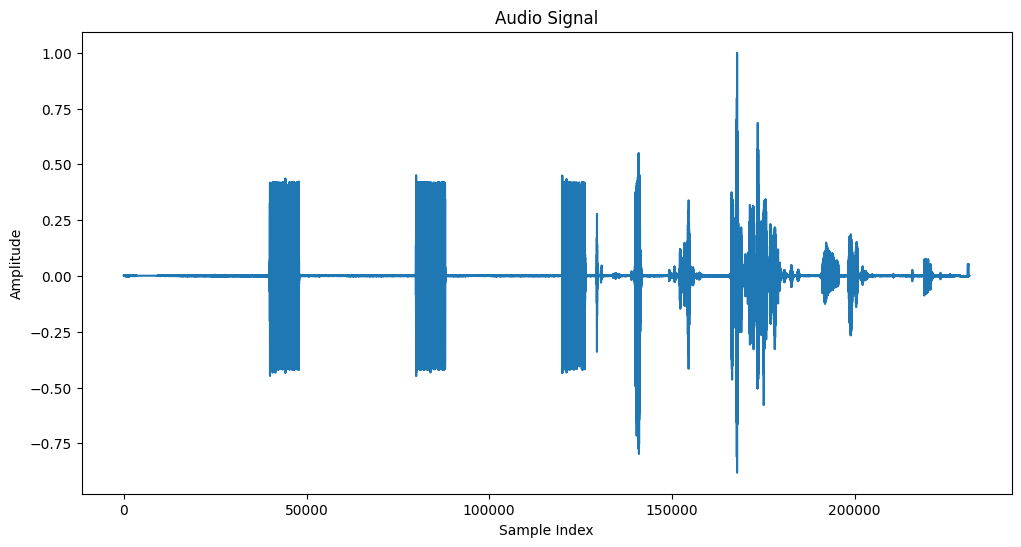

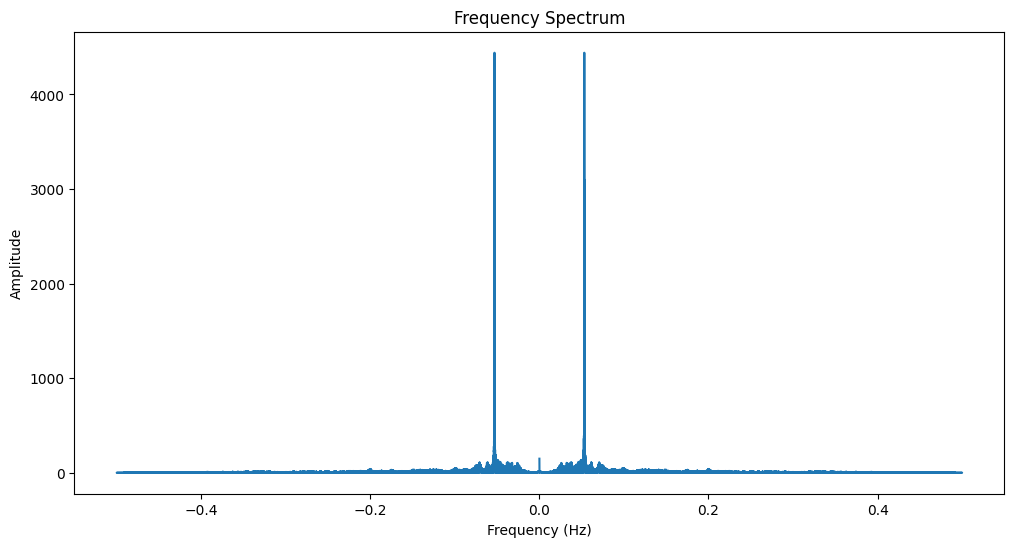

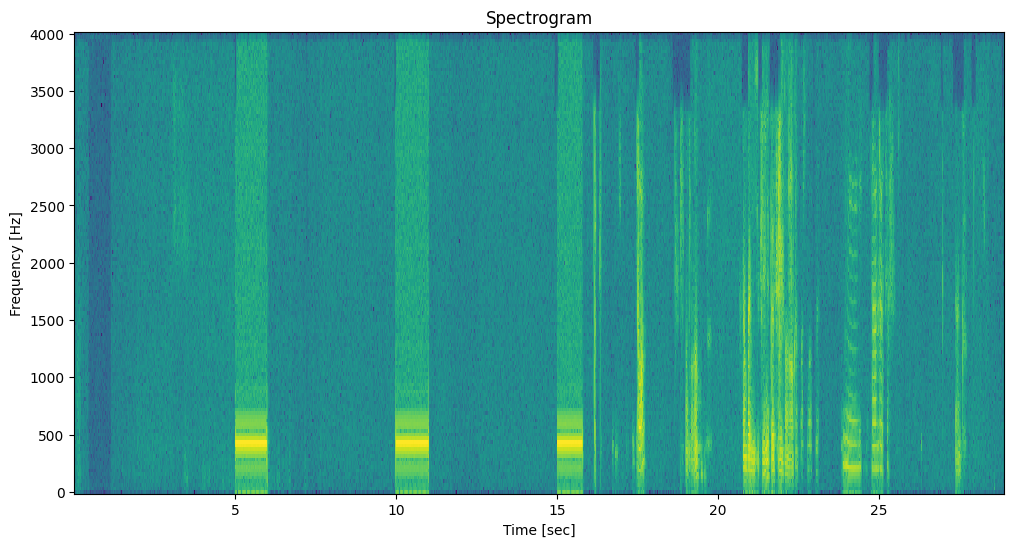

In [ ]:
from pydub import AudioSegment
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft

# Преобразовать аудиофайл в массив данных
audio = AudioSegment.from_file("train/1652862896.382947.wav")
audio_data = np.array(audio.get_array_of_samples())

# Нормализация данных
audio_data = audio_data / np.max(np.abs(audio_data))

# Визуализация исходного аудиосигнала
plt.figure(figsize=(12, 6))
plt.plot(audio_data)
plt.title("Audio Signal")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.show()

# Частотный анализ (FFT)
audio_fft = fft(audio_data)
audio_freq = np.fft.fftfreq(len(audio_fft))

# Визуализация спектра
plt.figure(figsize=(12, 6))
plt.plot(audio_freq, np.abs(audio_fft))
plt.title("Frequency Spectrum")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.show()

# Дополнительно можно извлечь спектральные характеристики
from scipy.signal import spectrogram

frequencies, times, spectrogram_data = spectrogram(audio_data, fs=audio.frame_rate)

plt.figure(figsize=(12, 6))
plt.pcolormesh(times, frequencies, np.log(spectrogram_data))
plt.title("Spectrogram")
plt.ylabel("Frequency [Hz]")
plt.xlabel("Time [sec]")
plt.show()


Количество гудков: 3


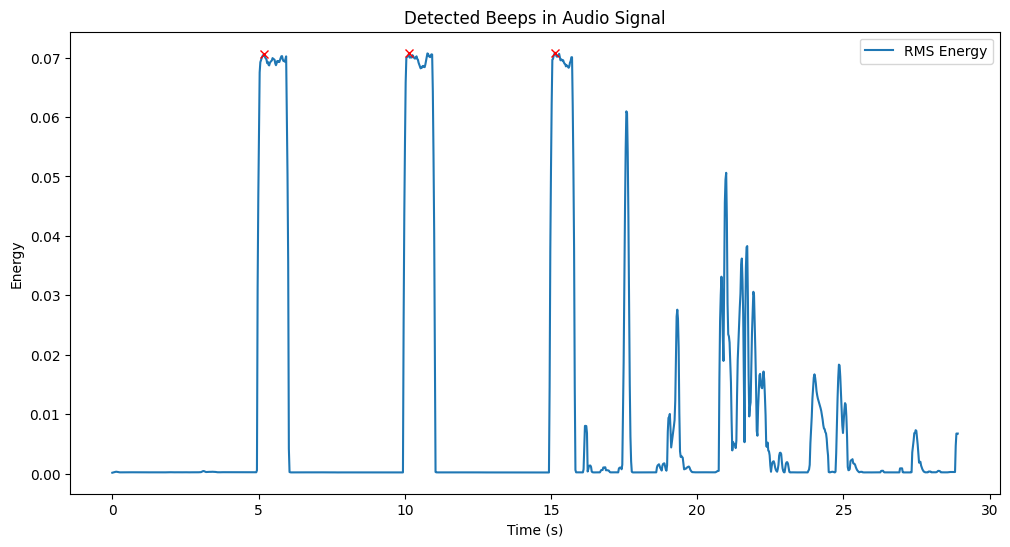

In [67]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Загружаем аудиофайл
y, sr = librosa.load("train/1652862896.382947.wav")

# Извлекаем энергию сигнала (Root Mean Square Energy)
frame_length = 2048
hop_length = 512
rms = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)[0]

# Находим пики в энергии, которые соответствуют гудкам
peaks, _ = find_peaks(rms, height=np.mean(rms) + 0.5 * np.std(rms), distance=sr/(hop_length*2))

# Объединяем соседние пики, если они находятся близко друг к другу
min_distance = 0.4  # Минимальное расстояние между пиками в секундах
min_samples = -30

# Группируем пики, которые находятся ближе друг к другу, чем min_samples
current_group = []

for i in range(len(peaks)-1):
    if peaks[i] - peaks[i+1] >= min_samples:
        current_group.append(peaks[i])


# Количество гудков
num_beeps = len(current_group)
print("Количество гудков:", num_beeps)

# Визуализация энергии сигнала и обнаруженных пиков
times = librosa.times_like(rms, sr=sr, hop_length=hop_length)
plt.figure(figsize=(12, 6))
plt.plot(times, rms, label='RMS Energy')
for group in current_group:
    plt.plot(times[group], rms[group], 'rx')
plt.xlabel('Time (s)')
plt.ylabel('Energy')
plt.title('Detected Beeps in Audio Signal')
plt.legend()
plt.show()
